In [ ]:
import pandas as pd
import tqdm
import os
from feature_extractor import extract_features, feature_names

image_dir = "koniq10k_512x384"
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Processing {len(image_files)} images")

In [ ]:
all_features = []
for img_path in tqdm.tqdm(image_files, desc="Extracting features"):
    try:
        all_features.append(extract_features(img_path))
    except Exception as e:
        print(f"Error: {img_path}: {e}")

df_features = pd.DataFrame(all_features, columns=feature_names)
df_features['image_path'] = [os.path.basename(p) for p in image_files]
df_features.to_csv("features.csv", index=False)
print(f"Features: {df_features.shape}")

In [ ]:
from iqa_scorers import compute_all_scores
compute_all_scores("koniq10k_512x384")

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import json

df_scores = pd.read_csv("iqa_raw_scores.csv")
df_mos = pd.read_csv("koniq10k_scores_and_distributions.csv")
df_features = pd.read_csv("features.csv")

if 'image_name' not in df_scores.columns:
    df_scores.columns = ['image_name'] + list(df_scores.columns[1:])

df = df_scores.merge(df_mos[["image_name", "MOS"]], on="image_name")
df = df.merge(df_features, left_on="image_name", right_on="image_path")

iqa_methods = ["brisque", "niqe", "piqe", "maniqa", "hyperiqa"]

mos_predictions = {}
regression_coefficients = {}

for method in iqa_methods:
    reg = LinearRegression()
    X = df[[method]].values
    y = df["MOS"].values
    reg.fit(X, y)
    mos_predictions[f"{method}_mos"] = reg.predict(X)
    regression_coefficients[method] = {'coef': float(reg.coef_[0]), 'intercept': float(reg.intercept_)}
    print(f"{method}: R²={reg.score(X, y):.4f}")

with open("mos_mapping_coefficients.json", "w") as f:
    json.dump(regression_coefficients, f, indent=2)

errors = {method: np.abs(mos_predictions[f"{method}_mos"] - df["MOS"].values) for method in iqa_methods}
errors_df = pd.DataFrame(errors)
df["best_method"] = errors_df.idxmin(axis=1)
df["best_method_label"] = df["best_method"].map({m: i for i, m in enumerate(iqa_methods)})
df["best_method_error"] = errors_df.min(axis=1)

print(f"\n{df['best_method'].value_counts()}")
df.to_csv("router_training_data.csv", index=False)
print(f"Dataset: {df.shape}")

Columns in iqa_raw_scores.csv: ['image_name', 'brisque', 'niqe', 'piqe', 'maniqa', 'hyperiqa']

First few rows:
        image_name    brisque      niqe       piqe    maniqa  hyperiqa
0  10004473376.jpg   9.552673  2.506198  40.236183  0.610917  0.739534
1  10007357496.jpg  21.367493  3.380887  33.191517  0.494540  0.715400
2  10007903636.jpg  -2.647888  3.127205  34.074223  0.614745  0.771971
3  10009096245.jpg  22.468445  2.867712  24.217449  0.548266  0.708292
4    100117038.jpg  21.107605  4.532191  26.955933  0.592131  0.714782

Filtered to 1000 selected images
Final merged dataset shape: (975, 27)
Columns: ['image_name', 'brisque', 'niqe', 'piqe', 'maniqa', 'hyperiqa', 'MOS', 'mean_luminance', 'std_luminance', 'skewness_luminance', 'kurtosis_luminance', 'entropy_luminance', 'median_luminance', 'colorfulness', 'mean_saturation', 'laplacian_variance', 'tenengrad', 'canny_edge_ratio', 'lbp_uniformity', 'noise_std_estimate', 'blockiness_energy', 'rms_contrast', 'percentile_contrast', 

STEP 5: TRAINING XGBOOST ROUTER

Training data shape: X=(975, 19), y=(975,)

Class distribution:
  0 (brisque     ):   56 ( 5.74%)
  1 (niqe        ):   73 ( 7.49%)
  2 (piqe        ):   58 ( 5.95%)
  3 (maniqa      ):  305 (31.28%)
  4 (hyperiqa    ):  483 (49.54%)

Train set: 780 samples
Test set:  195 samples

Standardizing features...

Training XGBoost router...
------------------------------------------------------------
[0]	validation_0-mlogloss:1.57103	validation_1-mlogloss:1.58499
[50]	validation_0-mlogloss:0.72421	validation_1-mlogloss:1.24469
[100]	validation_0-mlogloss:0.42725	validation_1-mlogloss:1.26513
[150]	validation_0-mlogloss:0.27668	validation_1-mlogloss:1.31253
[199]	validation_0-mlogloss:0.19276	validation_1-mlogloss:1.35242
------------------------------------------------------------

Evaluating router performance...

ROUTER PERFORMANCE
Train Accuracy: 1.0000
Test Accuracy:  0.4667

Classification Report (Test Set):
              precision    recall  f1-score   s

d:\Github\NR-IQA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Github\NR-IQA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Github\NR-IQA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



✓ Saved confusion matrix to confusion_matrix.png


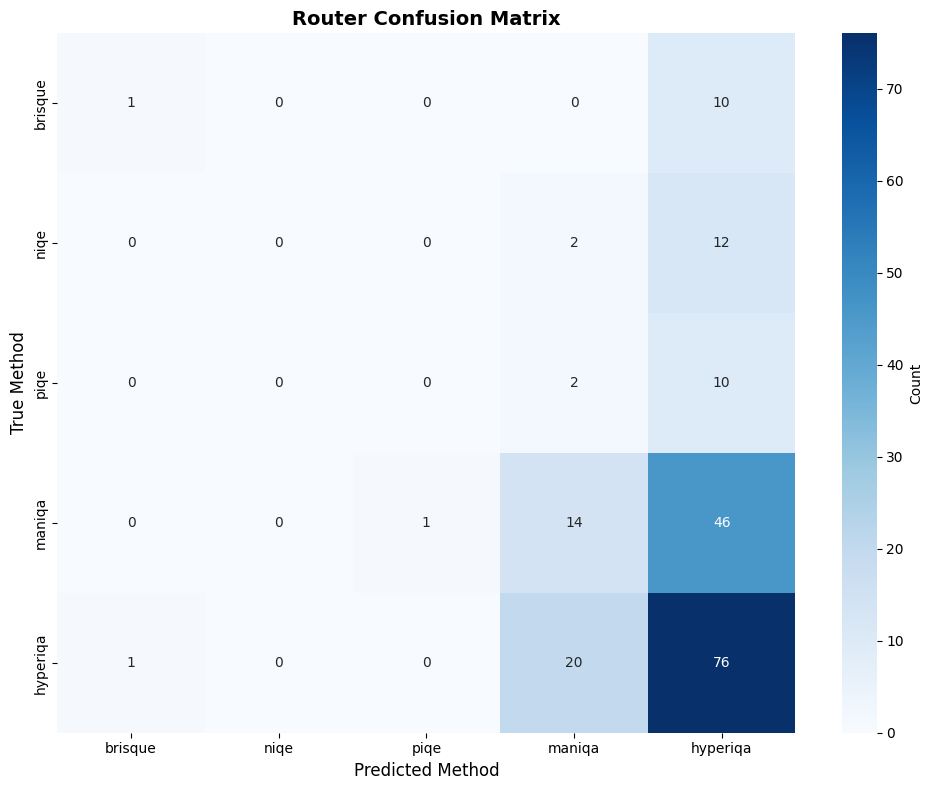


CONFIDENCE STATISTICS
Mean:   0.6381
Median: 0.6315
Std:    0.1333
Min:    0.3537
Max:    0.9197
✓ Saved confidence distribution to confidence_distribution.png


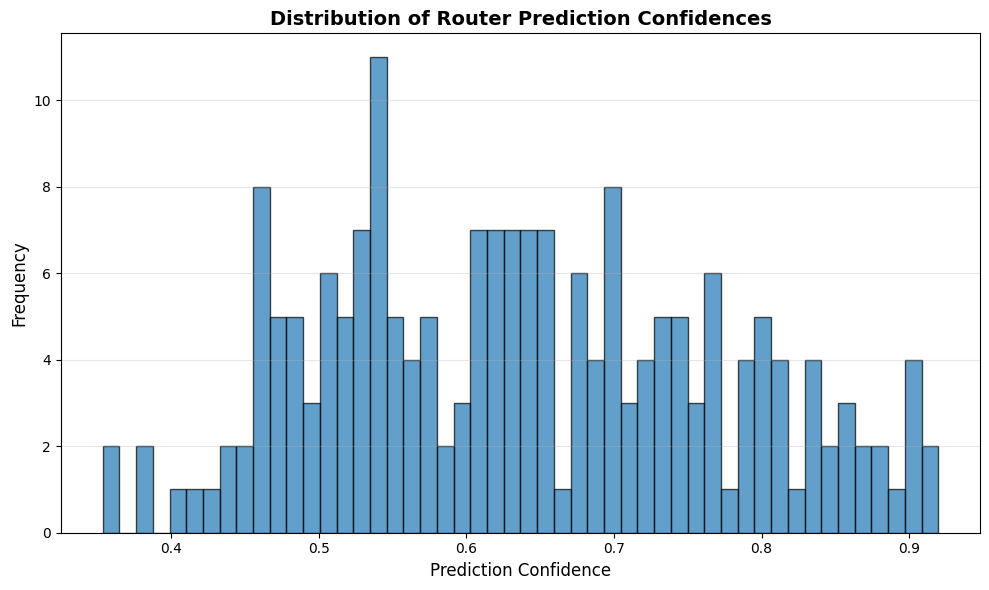


Saving model and scaler...
✓ Saved router model to router_xgb.json
✓ Saved scaler to scaler.pkl

STEP 5 COMPLETED SUCCESSFULLY


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

df = pd.read_csv("router_training_data.csv")
X = df[feature_names].values
y = df["best_method_label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

router = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, subsample=0.8, 
                       colsample_bytree=0.8, gamma=0.1, reg_lambda=1.0, reg_alpha=0.1,
                       objective="multi:softprob", num_class=5, n_jobs=-1, random_state=42, eval_metric="mlogloss")

router.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)], verbose=50)

y_pred_proba = router.predict_proba(X_test_scaled)
print(f"Train Acc: {accuracy_score(y_train, router.predict(X_train_scaled)):.4f}")
print(f"Test Acc: {accuracy_score(y_test, router.predict(X_test_scaled)):.4f}")
print(classification_report(y_test, router.predict(X_test_scaled), target_names=iqa_methods))

cm = confusion_matrix(y_test, router.predict(X_test_scaled))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iqa_methods, yticklabels=iqa_methods)
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

confidences = np.max(y_pred_proba, axis=1)
plt.figure(figsize=(10, 6))
plt.hist(confidences, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Confidence Distribution')
plt.savefig("confidence_distribution.png", dpi=300)
plt.show()

router.save_model("router_xgb.json")
joblib.dump(scaler, "scaler.pkl")
print(f"Confidence: mean={np.mean(confidences):.4f}, median={np.median(confidences):.4f}")

In [ ]:
importance = router.feature_importances_
indices = np.argsort(importance)[::-1]

for i in range(min(15, len(importance))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importance[indices[i]]:.4f}")

plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), importance[indices], color='steelblue')
plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()

pd.DataFrame({'Feature': [feature_names[i] for i in indices], 'Importance': importance[indices]}).to_csv("feature_importance.csv", index=False)

In [ ]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
sys.path.append('.')
import inference

df_full = pd.read_csv("router_training_data.csv")
_, test_df = train_test_split(df_full, test_size=0.2, random_state=42, stratify=df_full["best_method_label"])

predictions, confidences, selected_methods, times = [], [], [], []
for idx, row in tqdm.tqdm(test_df.iterrows(), total=len(test_df)):
    try:
        result = inference.predict(f"koniq10k_512x384/{row['image_name']}", confidence_threshold=0.5)
        predictions.append(result['MOS_estimate'])
        confidences.append(result['confidence'])
        selected_methods.append(result['selected_method'])
        times.append(result['timing']['total_time_ms'])
    except Exception as e:
        print(f"Error: {e}")

ground_truth = test_df['MOS'].values[:len(predictions)]

srocc = spearmanr(predictions, ground_truth)[0]
plcc = pearsonr(predictions, ground_truth)[0]
rmse = np.sqrt(mean_squared_error(ground_truth, predictions))
mae = mean_absolute_error(ground_truth, predictions)

print(f"SROCC: {srocc:.4f} | PLCC: {plcc:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | Time: {np.mean(times):.2f}ms")

baseline_results = {}
for method in iqa_methods:
    scores = test_df[method].values[:len(predictions)]
    method_mos = inference.mos_mapping[method]['coef'] * scores + inference.mos_mapping[method]['intercept']
    s = spearmanr(method_mos, ground_truth)[0]
    p = pearsonr(method_mos, ground_truth)[0]
    r = np.sqrt(mean_squared_error(ground_truth, method_mos))
    baseline_results[method] = {'SROCC': s, 'PLCC': p, 'RMSE': r}
    print(f"{method}: SROCC={s:.4f}, PLCC={p:.4f}, RMSE={r:.4f}")

plt.figure(figsize=(10, 10))
plt.scatter(ground_truth, predictions, alpha=0.5, s=30, edgecolors='black', linewidths=0.5)
plt.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect')
plt.xlabel('Ground Truth MOS')
plt.ylabel('Predicted MOS')
plt.title(f'SROCC={srocc:.4f}, PLCC={plcc:.4f}, RMSE={rmse:.4f}')
plt.legend()
plt.xlim(1, 5)
plt.ylim(1, 5)
plt.tight_layout()
plt.savefig("prediction_scatter.png", dpi=300)
plt.show()

pd.DataFrame({'image_name': test_df['image_name'].values[:len(predictions)], 'ground_truth': ground_truth, 
              'predicted': predictions, 'method': selected_methods, 'confidence': confidences,
              'time_ms': times, 'error': np.abs(predictions - ground_truth)}).to_csv("evaluation_results.csv", index=False)

pd.DataFrame({'Method': ['Adaptive'] + iqa_methods,
              'SROCC': [srocc] + [baseline_results[m]['SROCC'] for m in iqa_methods],
              'PLCC': [plcc] + [baseline_results[m]['PLCC'] for m in iqa_methods],
              'RMSE': [rmse] + [baseline_results[m]['RMSE'] for m in iqa_methods]}).to_csv("performance_summary.csv", index=False)